In [365]:
import ete3
import pandas as pd
import re
import multiprocessing
import numpy as np
import itertools
from scipy.spatial.distance import squareform
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.cluster import hierarchy
from sklearn import manifold
import networkx
import community
import random
import collections
import operator

%cd /work/kelsey/hgt/

/work/kelsey/hgt


In [2]:
def get_node_age_from_descendants(tree, descendants):
    node = tree.get_common_ancestor(descendants)
    return(node.support)

In [3]:
tree              = ete3.Tree('species_tree')
ranger_named_tree = ete3.Tree('species_tree_named_nodes', format=1)

genomes           = pd.read_csv('../genomes.tab', sep='\t', index_col=0)
genomes.Organism  = genomes.Organism.replace('\s+\(.+\)$', '', regex=True)

transfer_df       = pd.read_csv('transfers-filtered_by_confidence.tab', sep='\t', index_col=0)

name_conversion = {}
for index, row in genomes.iterrows():
    if index.startswith('GC'):
        name_conversion[row.abbreviation] = re.sub('\.\d+$', '', index, flags=re.M).replace('_', '')
    else:
        name_conversion[row.abbreviation] = row.accession.replace('_', '')

for leaf in tree.get_leaves():
    if leaf.name in name_conversion:
        leaf.add_feature('accession', name_conversion[leaf.name])
    else:
        leaf.add_feature('accession', leaf.name.replace('_', ''))

In [4]:
name_table = pd.DataFrame(columns=['name', 'accession'],
                          data=[(leaf.name, leaf.accession) for leaf in tree.get_leaves()])

for node in ranger_named_tree.traverse():
    if node.is_leaf():
        continue

    descendants     = name_table.loc[name_table.accession.isin(node.get_leaf_names()),
                                     'name'].values.tolist()
    equivalent      = tree.get_common_ancestor(descendants)
    equivalent.name = node.name

In [5]:
posterior_trees = [ete3.Tree(line)
                   for line in open('Cyano_modelBB_long_ugam_bd_7_20_sample.datedist').readlines()]

In [6]:
constraints = list(
    transfer_df.groupby(['donor', 'recipient']).groups.keys()
)

In [7]:
def assess_constraint_compatibility(constraint):
    older_bound   = next(tree.iter_search_nodes(name=constraint[0]))
    younger_bound = next(tree.iter_search_nodes(name=constraint[1]))
    
    compatibilities = []
    for tmp_tree in posterior_trees:
        older_bound_age   = get_node_age_from_descendants(tmp_tree,   older_bound.get_leaf_names())
        younger_bound_age = get_node_age_from_descendants(tmp_tree, younger_bound.get_leaf_names())
        
        if older_bound_age > younger_bound_age:
            compatibilities.append(True)
        else:
            compatibilities.append(False)

    return(compatibilities)

In [10]:
pool    = multiprocessing.Pool(processes=20)
results = pool.map(assess_constraint_compatibility, constraints)

compatibility_table = pd.DataFrame(columns=constraints,
                                   data   =np.array(results).T)

compatibility_count      = compatibility_table.sum()
compatibility_count.name = 'compatibility_count'

In [35]:
def jaccard_between_constraints(constraints):
    intersection = sum(compatibility_table[constraints].T.all())
    union        = sum(compatibility_table[constraints].T.any())
    
    if not union:
        return(0.0)
    else:
        return(intersection/union)

In [39]:
pairs_of_constraints = [list(pair) for pair in itertools.combinations(constraints, 2)]

In [44]:
pool                = multiprocessing.Pool(processes=20)
condensed_distances = np.array(
    pool.map(jaccard_between_constraints, pairs_of_constraints)
)

jaccard_distances = pd.DataFrame(index=constraints,
                                 columns=constraints,
                                 data=squareform(condensed_distances))

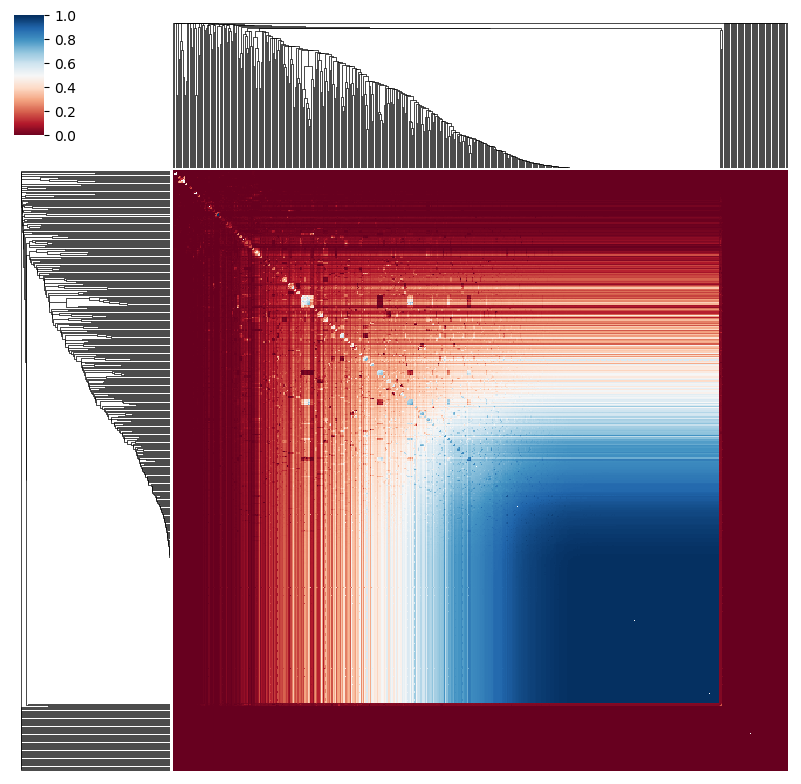

In [440]:
linkage = hierarchy.linkage(1-condensed_distances, method='average', metric='precomputed')

tmp_df = jaccard_distances.copy()
np.fill_diagonal(tmp_df.values, np.nan)

clst_map = sns.clustermap(tmp_df,
                          row_linkage=linkage,
                          col_linkage=linkage,
                          cmap='RdBu',
                          yticklabels=False,
                          xticklabels=False);
clst_map.fig.set_dpi(100)

In [85]:
tmp_df = 1-jaccard_distances
np.fill_diagonal(tmp_df.values, 0)

mds = manifold.MDS(n_components=2,
                   dissimilarity='precomputed',
                   random_state=12345)
mds_result = mds.fit(tmp_df)

coords     = mds_result.embedding_
x, y       = coords[:, 0], coords[:, 1]

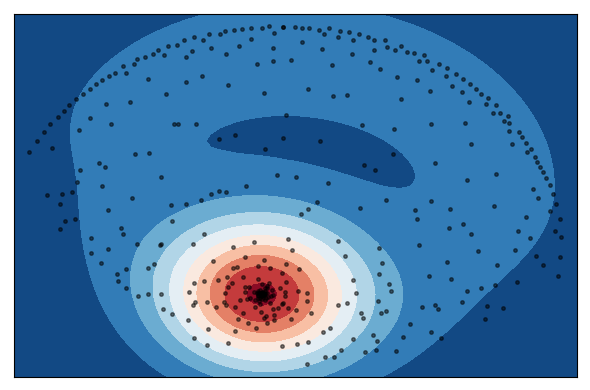

In [441]:
fig, ax = plt.subplots()

sns.kdeplot(x, y,
            bw=0.2,
            n_levels=9,
            cmap='RdBu_r',
            shade=True,
#            shade_lowest=False,
            ax=ax)

#sns.scatterplot(x, y,
#                hue=jaccard_distances.sum().values,
#                palette='RdBu',
#                alpha=0.5,
#                legend=False,
#                ax=ax);
ax.plot(x, y,
        '.k', 
        alpha=0.5, 
        markersize=5)

ax.tick_params(axis='both',
               which='both',
               bottom=False,
               labelbottom=False,
               left=False,
               labelleft=False)
#ax.axis('equal')
ax.set_xlim(x.min()-0.05, x.max()+0.05)
ax.set_ylim(y.min()-0.05, y.max()+0.05)
fig.set_dpi(100)
fig.tight_layout()

In [336]:
tmp_df         = jaccard_distances.copy()
tmp_df.index   = range(526)
tmp_df.columns = range(526)

In [337]:
graph   = networkx.convert_matrix.from_pandas_adjacency(tmp_df)
louvain = community.best_partition(graph)

In [369]:
clusters = []
for count, constraint in enumerate(constraints):
    clusters.append(louvain[count])

cluster_frequencies     = dict(collections.Counter(clusters))
clusters_sorted_by_size = sorted(cluster_frequencies.items(), key=operator.itemgetter(1), reverse=True)

In [420]:
cluster_coords = pd.DataFrame(columns='x y cluster'.split(), data=zip(x,y, clusters))
cluster_coords['cluster_size'] = 'none'
for cluster_num in cluster_coords.cluster.unique():
    if cluster_frequencies[cluster_num] >=3:
        cluster_coords.loc[cluster_coords.cluster==cluster_num, 'cluster_size'] = cluster_frequencies[cluster_num]
    else:
        continue

cluster_coords.index = constraints
cluster_coords       = cluster_coords.join(compatibility_count)

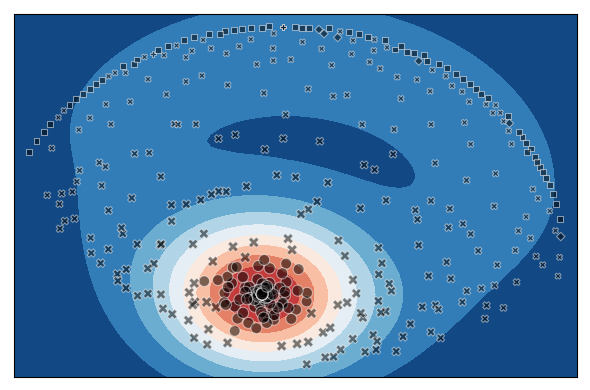

In [442]:
fig, ax = plt.subplots()

sns.kdeplot(x, y,
            bw=0.2,
            n_levels=9,
            cmap='RdBu_r',
            shade=True,
            ax=ax)

sns.scatterplot(x='x', 
                y='y',
                style='cluster_size',
                data=cluster_coords,
                alpha=0.5,
                size='compatibility_count',
                color='black',
                legend=False,
                ax=ax);

ax.tick_params(axis='both',
               which='both',
               bottom=False,
               labelbottom=False,
               left=False,
               labelleft=False)
#ax.axis('equal')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xlim(x.min()-0.05, x.max()+0.05)
ax.set_ylim(y.min()-0.05, y.max()+0.05)
fig.set_dpi(100)
fig.tight_layout()